# exponential smoothing model

# Loading and Manipulating the Data

In [1]:
from darts import TimeSeries
import pandas as pd
from darts.models import ExponentialSmoothing
from darts.utils.utils import SeasonalityMode
from darts.utils.utils import ModelMode
from darts.metrics import rmse

In [2]:
import pandas as pd
df_master = pd.read_pickle('/path/to/pklFiles/df_master.pkl')

In [3]:
df_master.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'release', 'wm_yr_wk', 'sell_price', 'price_max', 'price_min',
       'price_std', 'price_mean', 'price_norm', 'price_nunique',
       'item_nunique', 'price_momentum', 'price_momentum_m',
       'price_momentum_y', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'tm_d', 'tm_m', 'tm_y',
       'tm_wm', 'tm_dw', 'tm_w_end', 'date'],
      dtype='object')

In [4]:
df_master = df_master.sort_values(['id', 'date'])
df_master.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk,...,snap_CA,snap_TX,snap_WI,tm_d,tm_m,tm_y,tm_wm,tm_dw,tm_w_end,date
576,CA_1_FOODS_1_001,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,3.0,0,11101,...,0,0,0,29,1,0,5,5,1,2011-01-29
11508,CA_1_FOODS_1_001,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,0.0,0,11101,...,0,0,0,30,1,0,5,6,1,2011-01-30
22440,CA_1_FOODS_1_001,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0.0,0,11101,...,0,0,0,31,1,0,5,0,0,2011-01-31
33372,CA_1_FOODS_1_001,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,1.0,0,11101,...,1,1,0,1,2,0,1,1,0,2011-02-01
44304,CA_1_FOODS_1_001,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4.0,0,11101,...,1,0,1,2,2,0,1,2,0,2011-02-02


creating a smaller Dataframe for this simple Model

In [5]:
df_master_smaller = df_master[['id', 'date','d', 'sales']].copy()
del df_master

Creating the timeseries with Darts

In [6]:
from darts import TimeSeries
# Dictionaries for storing the series
target_series_dict = {}

# Group by 'id' to isolate each item+store
for i_id, group_df in df_master_smaller.groupby('id', sort=False, observed=False):
    # Sort within the group by date (just to be safe)
    group_df = group_df.sort_values('date')
    
    # --- TARGET SERIES (sales) ---
    target_series = TimeSeries.from_dataframe(
        df=group_df,
        time_col='date',       # The column that holds your dates
        value_cols='sales',    # The column(s) you want as your target
        freq='D'               # Daily frequency (adjust if your data is weekly, etc.)
    )
    
    # Store in the dictionaries
    target_series_dict[i_id] = target_series

print(f"Created {len(target_series_dict)} target series")

Created 30490 target series


Checking the type of my data

In [7]:
some_id = list(target_series_dict.keys())[0]
print(target_series_dict[some_id].dtype)  

float64


Splitting the training and validation Timeseries to Lists of Timeseries

In [13]:
import numpy as np

train_target_list = []
val_target_list = []
test_target_list = []
train_n_val_list = []

all_ids = (target_series_dict.keys())
#forecast_horizon = 28  # e.g., 28 days of validation

for i_id in all_ids:
    full_target_series = target_series_dict[i_id]
    print(i_id)

    train_target, val_target, train_n_val_target, test_target = full_target_series[:-56], full_target_series[-56:-28],full_target_series[:-28], full_target_series[-28:]

    # --- CAST HERE to float32 ---
    train_target = train_target.astype(np.float32)
    val_target = val_target.astype(np.float32)
    test_target = test_target.astype(np.float32)
    train_n_val_target = train_n_val_target.astype(np.float32)

    train_target_list.append(train_target)
    val_target_list.append(val_target)
    test_target_list.append(test_target)
    train_n_val_list.append(train_n_val_target)


print(f"Number of series: {len(all_ids)}")
print(f"Example training series length: {train_target_list[0].n_timesteps}")
print(f"Example validation series length: {val_target_list[0].n_timesteps}")

CA_1_FOODS_1_001
CA_1_FOODS_1_002
CA_1_FOODS_1_003
CA_1_FOODS_1_004
CA_1_FOODS_1_005
CA_1_FOODS_1_006
CA_1_FOODS_1_008
CA_1_FOODS_1_009
CA_1_FOODS_1_010
CA_1_FOODS_1_011
CA_1_FOODS_1_012
CA_1_FOODS_1_013
CA_1_FOODS_1_014
CA_1_FOODS_1_015
CA_1_FOODS_1_016
CA_1_FOODS_1_017
CA_1_FOODS_1_018
CA_1_FOODS_1_019
CA_1_FOODS_1_020
CA_1_FOODS_1_021
CA_1_FOODS_1_022
CA_1_FOODS_1_023
CA_1_FOODS_1_024
CA_1_FOODS_1_025
CA_1_FOODS_1_026
CA_1_FOODS_1_027
CA_1_FOODS_1_028
CA_1_FOODS_1_029
CA_1_FOODS_1_030
CA_1_FOODS_1_031
CA_1_FOODS_1_032
CA_1_FOODS_1_033
CA_1_FOODS_1_034
CA_1_FOODS_1_035
CA_1_FOODS_1_036
CA_1_FOODS_1_037
CA_1_FOODS_1_038
CA_1_FOODS_1_039
CA_1_FOODS_1_040
CA_1_FOODS_1_041
CA_1_FOODS_1_042
CA_1_FOODS_1_043
CA_1_FOODS_1_044
CA_1_FOODS_1_045
CA_1_FOODS_1_046
CA_1_FOODS_1_047
CA_1_FOODS_1_048
CA_1_FOODS_1_049
CA_1_FOODS_1_050
CA_1_FOODS_1_051
CA_1_FOODS_1_052
CA_1_FOODS_1_053
CA_1_FOODS_1_054
CA_1_FOODS_1_055
CA_1_FOODS_1_056
CA_1_FOODS_1_057
CA_1_FOODS_1_058
CA_1_FOODS_1_059
CA_1_FOODS_1_0

this output ensures that my Timeseries are indeed in alphabetical order

In [9]:
print(train_target_list[0].dtype)        # should be float32

float32


# Training phase

# Testing
Training one Timeseries to see how my model behaves

In [14]:
all_ids = list(all_ids)

validation forecast

In [ ]:
from darts.models import ExponentialSmoothing
from darts.metrics import rmse
from darts.utils.utils import ModelMode, SeasonalityMode
# Retrieve the first id and corresponding TimeSeries
first_id = all_ids[0]
train_series_example = train_target_list[0]
val_series_example = val_target_list[0]

# Initialize the Exponential Smoothing model with additive trend and seasonality
model_example = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7,random_state=42)  

# Fit the model on the training set
model_example.fit(train_series_example)

# Forecast the next 28 points (same length as val)
forecast_example = model_example.predict(n=28)

# Calculate RMSE between the forecast and actual validation series
error_rmse_example = rmse(val_series_example, forecast_example)

# Print the RMSE with the correct id
print(f"{first_id} -> RMSE: {error_rmse_example:.2f}")


CA_1_FOODS_1_001 -> RMSE: 1.38


test forecast


In [17]:
from darts.models import ExponentialSmoothing
from darts.metrics import rmse
from darts.utils.utils import ModelMode, SeasonalityMode
# Retrieve the first id and corresponding TimeSeries
first_id = all_ids[0]
train_series_example = train_n_val_list[0]
test_series_example = test_target_list[0]

# Initialize the Exponential Smoothing model with additive trend and seasonality
model_example = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7,random_state=42)  

# Fit the model on the training set
model_example.fit(train_series_example)

# Forecast the next 28 points (same length as val)
forecast_example = model_example.predict(n=28)

# Calculate RMSE between the forecast and actual validation series
error_rmse_example = rmse(test_series_example, forecast_example)

# Print the RMSE with the correct id
print(f"{first_id} -> RMSE: {error_rmse_example:.2f}")


CA_1_FOODS_1_001 -> RMSE: 1.90


<Axes: xlabel='date'>

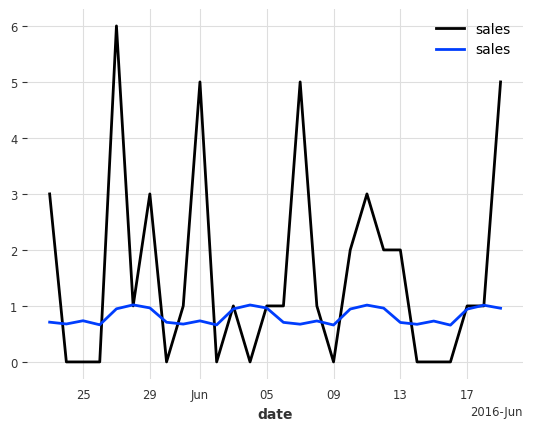

In [18]:
test_series_example.plot()
forecast_example.plot()

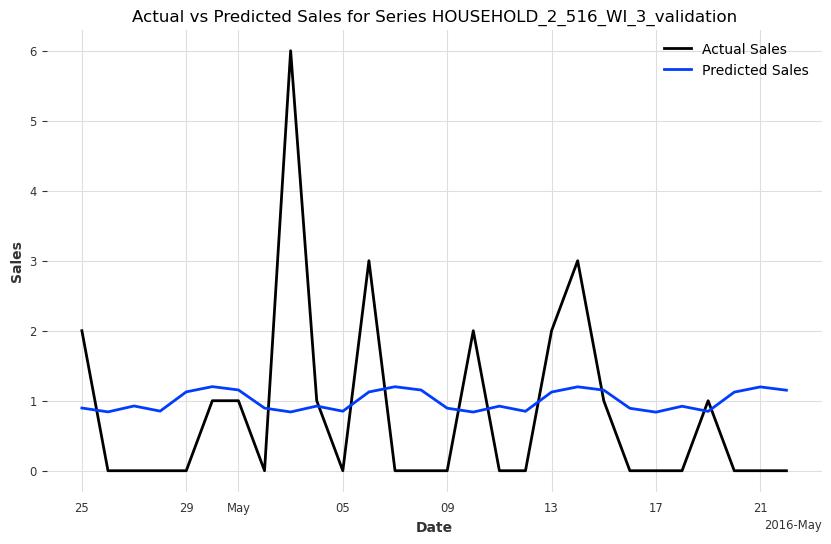

In [15]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))

# Plot the actual values
val_series_example.plot(label="Actual Sales")

# Plot the predicted values
forecast_example.plot(label="Predicted Sales")

# Add title and labels
plt.title(f"Actual vs Predicted Sales for Series {i_id}")
plt.xlabel("Date")
plt.ylabel("Sales")

# Add a legend
plt.legend()

# Show the plot
plt.show()

Trying Darts Backtest

historical forecasts:   0%|          | 0/143 [00:00<?, ?it/s]

Backtest RMSE: 0.88


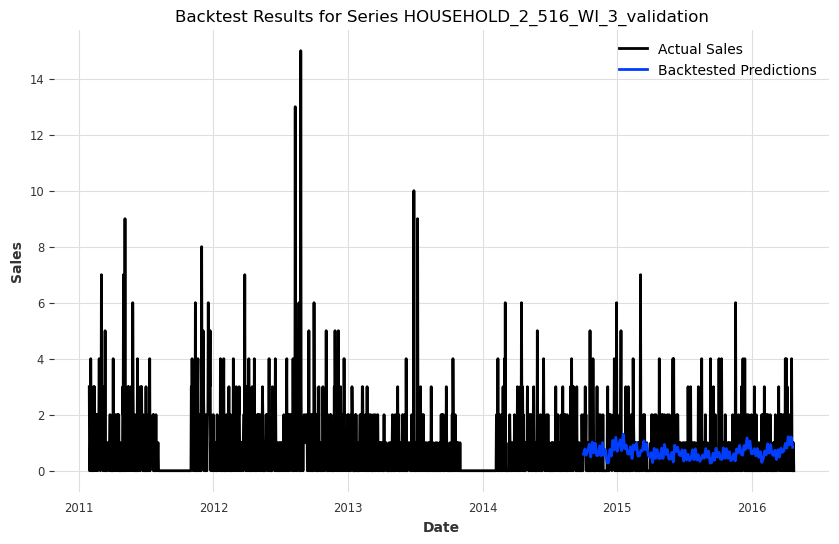

In [37]:
from darts.models import ExponentialSmoothing
from darts.metrics import rmse, mape
from darts.utils.utils import ModelMode, SeasonalityMode
import matplotlib.pyplot as plt

# Define the model
model_example_backtest = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE)
model_example_backtest.fit(train_series_example)
# Perform backtesting
# historical_forecasts will train the model on the training set and predict the validation set
backtest_series = model_example_backtest.historical_forecasts(
    series=train_series_example,  # Use the full training series
    start=0.7,                   # Start backtesting after 70% of the training data
    forecast_horizon=4,         # Forecast horizon (28 days)
    stride=4,                   # Move forward 28 days after each iteration
    retrain=True,               # Can not be False in ES
    verbose=True,                # Print progress
)

# Calculate evaluation metrics
error_rmse = rmse(train_series_example, backtest_series)

print(f"Backtest RMSE: {error_rmse:.2f}")

# Plot the actual vs backtested predictions
plt.figure(figsize=(10, 6))
train_series_example.plot(label="Actual Sales")
backtest_series.plot(label="Backtested Predictions")
plt.title(f"Backtest Results for Series {i_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Training
actually training all my dataset

In [16]:
from darts.models import ExponentialSmoothing
from tqdm.notebook import tqdm
from darts.utils.utils import SeasonalityMode
from darts.utils.utils import ModelMode


forecasts_list = []

for i_id in tqdm(all_ids, desc="Forecasting series"):
    # Prepare training & validation series
    # (assuming train_target_list and val_target_list have the same order as all_ids)
    i = all_ids.index(i_id)
    train_series = train_target_list[i]
    val_series = val_target_list[i]
    
    # Initialize ARIMA model
    model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7,random_state=42)
    
    # Fit
    model.fit(train_series)
    
    # Predict
    forecast = model.predict(n=len(val_series))
    
    # Store the forecast
    forecasts_list.append(forecast)
    
    # Optional: Print info about each forecast
    print(f"Forecasted {i_id}: val length={len(val_series)}, forecast length={len(forecast)}")

Forecasting series:   0%|          | 0/30490 [00:00<?, ?it/s]

Forecasted FOODS_1_001_CA_1_validation: val length=28, forecast length=28
Forecasted FOODS_1_001_CA_2_validation: val length=28, forecast length=28
Forecasted FOODS_1_001_CA_3_validation: val length=28, forecast length=28
Forecasted FOODS_1_001_CA_4_validation: val length=28, forecast length=28
Forecasted FOODS_1_001_TX_1_validation: val length=28, forecast length=28
Forecasted FOODS_1_001_TX_2_validation: val length=28, forecast length=28
Forecasted FOODS_1_001_TX_3_validation: val length=28, forecast length=28
Forecasted FOODS_1_001_WI_1_validation: val length=28, forecast length=28
Forecasted FOODS_1_001_WI_2_validation: val length=28, forecast length=28
Forecasted FOODS_1_001_WI_3_validation: val length=28, forecast length=28
Forecasted FOODS_1_002_CA_1_validation: val length=28, forecast length=28
Forecasted FOODS_1_002_CA_2_validation: val length=28, forecast length=28
Forecasted FOODS_1_002_CA_3_validation: val length=28, forecast length=28
Forecasted FOODS_1_002_CA_4_validation

In [18]:
import pickle

# Specify the file path where you want to save the dictionary
file_path = "/path/to/BasicModels/ExponentialSmoothing/forcast_list.pkl"

# Save the dictionary to a .pkl file
with open(file_path, "wb") as file:
    pickle.dump(forecasts_list, file)

# Evaluation and Statistics

# Weighted eval

Reading the weights provided by the M5 competition to compute the WRMSSE

In [39]:
weights_df = pd.read_csv("../ExtraFiles/weights_validation.csv")

# We only want rows for Level12
weights_df = weights_df[weights_df["Level_id"] == "Level12"].copy()

# Create a new 'id' column by combining Agg_Level_1 and Agg_Level_2
weights_df["id"] = weights_df["Agg_Level_1"] + "_" + weights_df["Agg_Level_2"] + "_validation"


weights_df = weights_df.sort_values(['id'])
# Build a dictionary: {id_string: weight_value}
weights_map = dict(zip(weights_df["id"], weights_df["weight"]))

In [41]:
weights_df.head()

,Level_id,Agg_Level_1,Agg_Level_2,Dollar_Sales,weight,id
1612,Level12,FOODS_1_001,CA_1,73.92,1.972157e-05,FOODS_1_001_CA_1_validation
4661,Level12,FOODS_1_001,CA_2,69.44,1.852633e-05,FOODS_1_001_CA_2_validation
7710,Level12,FOODS_1_001,CA_3,53.76,1.434296e-05,FOODS_1_001_CA_3_validation
10759,Level12,FOODS_1_001,CA_4,20.16,5.378610e-06,FOODS_1_001_CA_4_validation
13808,Level12,FOODS_1_001,TX_1,2.24,5.976230e-07,FOODS_1_001_TX_1_validation


In [42]:
weights_df.tail()

,Level_id,Agg_Level_1,Agg_Level_2,Dollar_Sales,weight,id
16856,Level12,HOUSEHOLD_2_516,TX_2,47.52,0.000013,HOUSEHOLD_2_516_TX_2_validation
19905,Level12,HOUSEHOLD_2_516,TX_3,29.70,0.000008,HOUSEHOLD_2_516_TX_3_validation
22954,Level12,HOUSEHOLD_2_516,WI_1,5.94,0.000002,HOUSEHOLD_2_516_WI_1_validation
26003,Level12,HOUSEHOLD_2_516,WI_2,5.94,0.000002,HOUSEHOLD_2_516_WI_2_validation
29052,Level12,HOUSEHOLD_2_516,WI_3,0.00,0.000000,HOUSEHOLD_2_516_WI_3_validation


In [48]:
import numpy as np

wrmsse_numer = 0.0  # Accumulator for w_i * RMSSE_i
wrmsse_denom = 0.0  # Accumulator for w_i

for i, i_id in enumerate(all_ids):
    # 1) Get the weight for this item (default 0 if not in map)
    w_i = weights_map.get(i_id, 0.0)
    
    # 2) Training data for computing scaling factor
    train_ts = train_target_list[i]
    train_vals = train_ts.values().ravel()  # shape (n,)  
    # If necessary, handle any corner cases (very short series, all zeros, etc.)
    
    # 3) Validation actuals & forecast
    val_ts = val_target_list[i]
    forecast_ts = forecasts_list[i]
    actual_vals = val_ts.values().ravel()
    pred_vals   = forecast_ts.values().ravel()
    
    # Make sure lengths match, just to be safe
    if len(actual_vals) != len(pred_vals):
        raise ValueError(f"Mismatch in forecast vs actual length for {i_id}")
    
    # -----------------
    # Compute MSE (numerator)
    # -----------------
    mse = np.mean((pred_vals - actual_vals)**2)
    
    # -----------------
    # Compute scaling factor (denominator of RMSSE)
    # sum of squared first differences on training set
    # -----------------
    diffs = np.diff(train_vals)  # shape (n-1,)
    denom = np.mean(diffs**2)    # average of squared diffs
    # If denom is 0, that means the training series had no variability
    # Handle gracefully to avoid division-by-zero
    if denom == 0.0:
        # E.g. skip or define RMSSE = 0 if there's literally no variation in training
        rmsse_i = 0.0
    else:
        # RMSSE = sqrt( MSE / denom )
        rmsse_i = np.sqrt(mse / denom)
    
    # Accumulate
    wrmsse_numer += w_i * rmsse_i

# Final Weighted RMSSE
wrmsse = wrmsse_numer 
print(f"WRMSSE = {wrmsse:.6f}")

WRMSSE = 0.847827


# Normal RMSE

In [19]:
rmse_list = []

for i in range(len(all_ids)):
    forecast = forecasts_list[i]
    val_series = val_target_list[i]

    error_rmse = rmse(val_series, forecast)
    rmse_list.append(error_rmse)

mean_rmse = np.mean(rmse_list)

# Print the mean RMSE
print(f"\nMean RMSE across all series: {mean_rmse:.2f}")


Mean RMSE across all series: 1.37


In [20]:
# Create a DataFrame with 'id' and 'RMSE'
metrics_df = pd.DataFrame({
    'id': all_ids,
    'RMSE': rmse_list
})


In [21]:
# Calculate additional statistics
mean_rmse = metrics_df['RMSE'].mean()
median_rmse = metrics_df['RMSE'].median()
std_rmse = metrics_df['RMSE'].std()
min_rmse = metrics_df['RMSE'].min()
max_rmse = metrics_df['RMSE'].max()

# Print the statistics
print("\nRMSE Statistics:")
print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Median RMSE: {median_rmse:.2f}")
print(f"Standard Deviation of RMSE: {std_rmse:.2f}")
print(f"Minimum RMSE: {min_rmse:.2f}")
print(f"Maximum RMSE: {max_rmse:.2f}")



RMSE Statistics:
Mean RMSE: 1.37
Median RMSE: 0.92
Standard Deviation of RMSE: 1.72
Minimum RMSE: 0.01
Maximum RMSE: 42.29


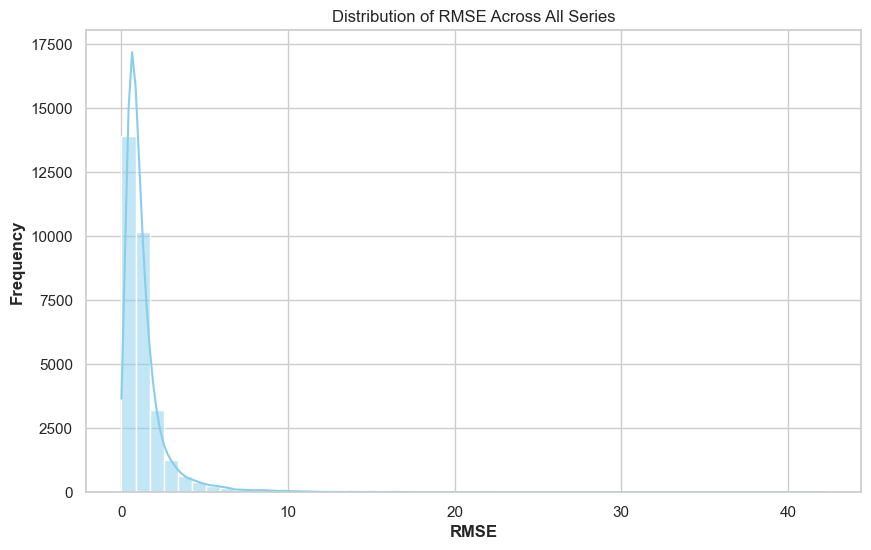

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot a histogram of RMSE values
plt.figure(figsize=(10, 6))
sns.histplot(metrics_df['RMSE'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of RMSE Across All Series')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.show()


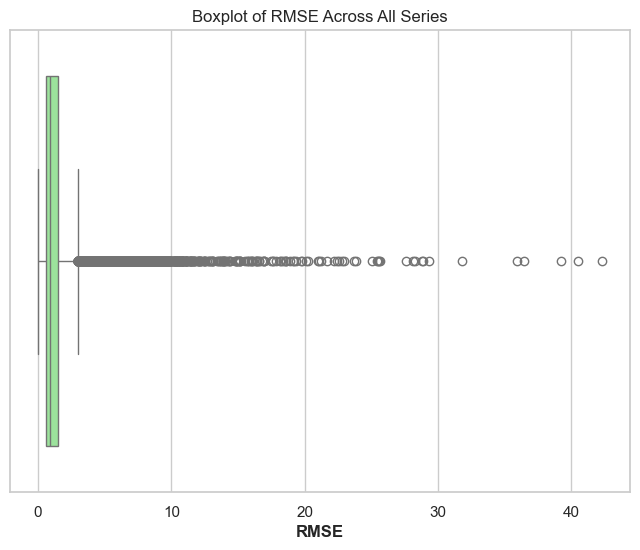

In [54]:
# Plot a boxplot of RMSE values
plt.figure(figsize=(8, 6))
sns.boxplot(x=metrics_df['RMSE'], color='lightgreen')
plt.title('Boxplot of RMSE Across All Series')
plt.xlabel('RMSE')
plt.show()


In [55]:
# Identify the top 5 series with the highest RMSE
top5_highest_rmse = metrics_df.sort_values(by='RMSE', ascending=False).head(5)
print("Top 5 Series with Highest RMSE:")
print(top5_highest_rmse)

# Identify the top 5 series with the lowest RMSE
top5_lowest_rmse = metrics_df.sort_values(by='RMSE').head(5)
print("\nTop 5 Series with Lowest RMSE:")
print(top5_lowest_rmse)


Top 5 Series with Highest RMSE:
                                id       RMSE
8468   FOODS_3_234_WI_2_validation  42.285260
10568  FOODS_3_444_WI_2_validation  40.508587
9888   FOODS_3_376_WI_2_validation  39.259474
11108  FOODS_3_498_WI_2_validation  36.471372
5748   FOODS_2_360_WI_2_validation  35.895649

Top 5 Series with Lowest RMSE:
                                    id      RMSE
26804  HOUSEHOLD_2_147_TX_1_validation  0.008251
26303  HOUSEHOLD_2_097_CA_4_validation  0.008959
26413  HOUSEHOLD_2_108_CA_4_validation  0.009247
16236    HOBBIES_1_192_TX_3_validation  0.009863
26414  HOUSEHOLD_2_108_TX_1_validation  0.011283


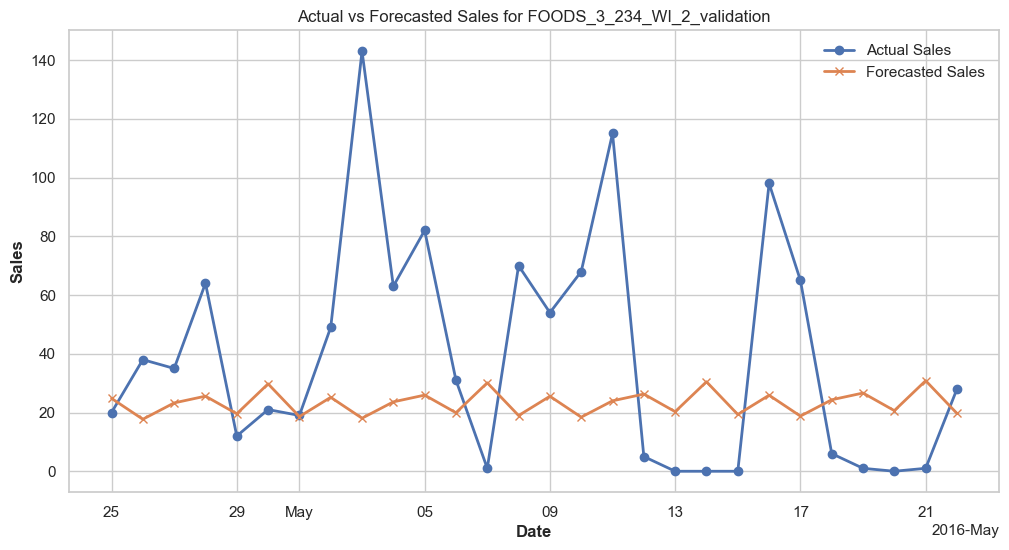

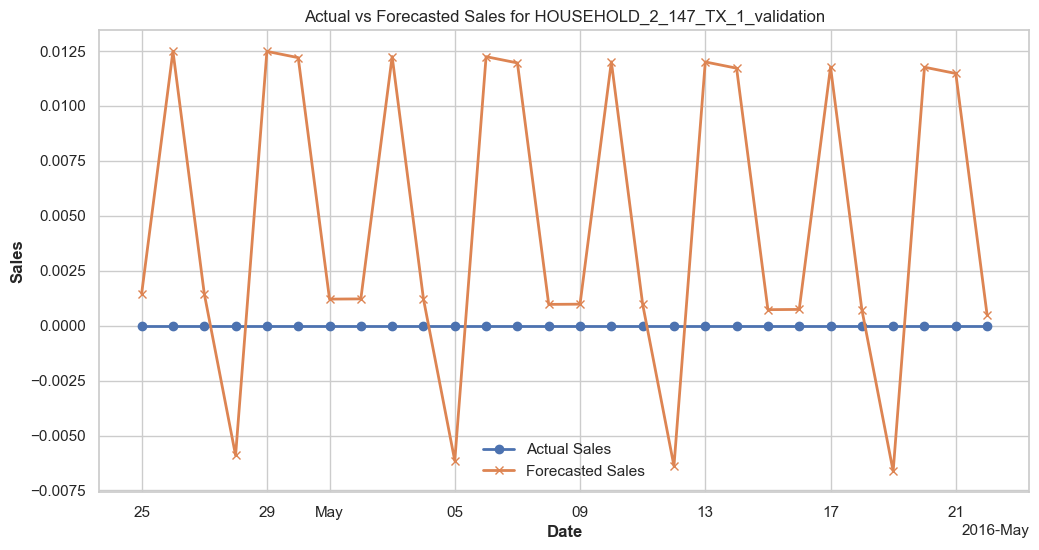

In [56]:
# Function to plot actual vs forecasted sales
def plot_actual_vs_forecast(id_, val_series, forecast):
    plt.figure(figsize=(12, 6))
    val_series.plot(label='Actual Sales', marker='o')
    forecast.plot(label='Forecasted Sales', marker='x')
    plt.title(f'Actual vs Forecasted Sales for {id_}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

# Plot for the series with the highest RMSE
highest_rmse_id = top5_highest_rmse.iloc[0]['id']
highest_rmse_index = metrics_df[metrics_df['id'] == highest_rmse_id].index[0]
plot_actual_vs_forecast(highest_rmse_id, val_target_list[highest_rmse_index], forecasts_list[highest_rmse_index])

# Plot for the series with the lowest RMSE
lowest_rmse_id = top5_lowest_rmse.iloc[0]['id']
lowest_rmse_index = metrics_df[metrics_df['id'] == lowest_rmse_id].index[0]
plot_actual_vs_forecast(lowest_rmse_id, val_target_list[lowest_rmse_index], forecasts_list[lowest_rmse_index])
